In [1]:
import torch

import os
# os.environ['TRITON_INTERPRET'] = '1'
import triton
import triton.language as tl
import math

DEVICE = triton.runtime.driver.active.get_active_torch_device()

In [2]:
def _get_cuda_autotune_config():
    configs = []
    for num_stages in [2,3,4,5]:
        for num_warps in [2,4,8]:
            for BLOCK_SIZE_M in [32, 64]: #, 128]:
                for BLOCK_SIZE_N in [32, 64]: #, 128]:
                    for BLOCK_SIZE_K in [16, 32]: #, 64]:
                        configs.append(
                            triton.Config(
                                {
                                    "GROUP_SIZE_M" : 8,
                                    "BLOCK_SIZE_M" : BLOCK_SIZE_M,
                                    "BLOCK_SIZE_N" : BLOCK_SIZE_N,
                                    "BLOCK_SIZE_K" : BLOCK_SIZE_K,
                                }, 
                                num_stages=num_stages, 
                                num_warps=num_warps
                            ),
                        )                        
    #return configs
    return [triton.Config(
                                {
                                    "GROUP_SIZE_M" : 8,
                                    "BLOCK_SIZE_M" : 32,
                                    "BLOCK_SIZE_N" : 64,
                                    "BLOCK_SIZE_K" : 16,
                                },
                                num_stages=2, 
                                num_warps=4
                            )]


In [3]:
@triton.jit
def to_int4(v):
    sign = (v & 0x8) != 0
    mag  = (v & 0x7).to(tl.int8)
    return tl.where(sign, -mag, mag)

@triton.autotune(
    configs=_get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
        # by to get the element one row down (A has M rows).
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # -----------------------------------------------------------
    # Add some integer bound assumptions.
    # This helps to guide integer analysis in the backend to optimize
    # load/store offset address calculation
    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetic` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bn = (pid_n * (BLOCK_SIZE_N // 2) + tl.arange(0, BLOCK_SIZE_N // 2)) % (N // 2)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator_dtype = tl.float32 #tl.float16 #tl.float32
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        
        b_bits = tl.load(b_ptrs) #, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        val0 = (b_bits >> 4) & 0xF
        val1 = b_bits & 0xF
        
        w0 = to_int4(val0)
        w1 = to_int4(val1)

        w01 = tl.join(w0, w1)
        b = tl.reshape(w01, BLOCK_SIZE_K, BLOCK_SIZE_N).to(tl.float16)

        # print(b)
        # raise

        # We accumulate along the K dimension.
        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def triton_matmul_int4_fp16(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    M, K = a.shape
    N = b.shape[1] * 2
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
    )
    return c


In [4]:
def decode_uint8_to_int4_python(bits):
    val0 = (bits >> 4) & 0xF
    val1 = bits & 0xF

    sign0 = (val0 & 0x8) != 0
    sign1 = (val1 & 0x8) != 0
    
    dtype = torch.int8

    mag0 = (val0 & 0x7).to(dtype)
    mag1 = (val1 & 0x7).to(dtype)
    
    w0 = torch.where(sign0, -mag0, mag0)
    w1 = torch.where(sign1, -mag1, mag1)

    return torch.stack([w0, w1], dim=-1)
    

torch.manual_seed(0)

M, N, K = 3 * (256,)#16, 16, 16

y = torch.randn(M, K, dtype=torch.float16, device="cuda") / (M * K)
x_compressed = torch.randint(0, 255, (K, N // 2), dtype=torch.uint8, device="cuda")
x_decompressed = decode_uint8_to_int4_python(x_compressed).reshape(K, N).to(torch.float16)

#print(x_compressed)
#print(x_decompressed)

o1 = torch.matmul(y, x_decompressed)
o2 = triton_matmul_int4_fp16(y, x_compressed)

assert torch.all(torch.isclose(o1, o2))

In [5]:
#print(matmul_kernel.best_config)

GROUP_SIZE_M: 8, BLOCK_SIZE_M: 32, BLOCK_SIZE_N: 64, BLOCK_SIZE_K: 16, num_warps: 4, num_ctas: 1, num_stages: 2, maxnreg: None


matmul-performance:
        M       N       K  torch_fp16  triton_int4_fp16
0   256.0   256.0   256.0    0.235476          0.830555
1   512.0   512.0   512.0    0.324511          1.453580
2  1024.0  1024.0  1024.0    0.327070          1.576713
3  2048.0  2048.0  2048.0    0.326514          1.484200
4  4096.0  4096.0  4096.0    0.353868          1.419813


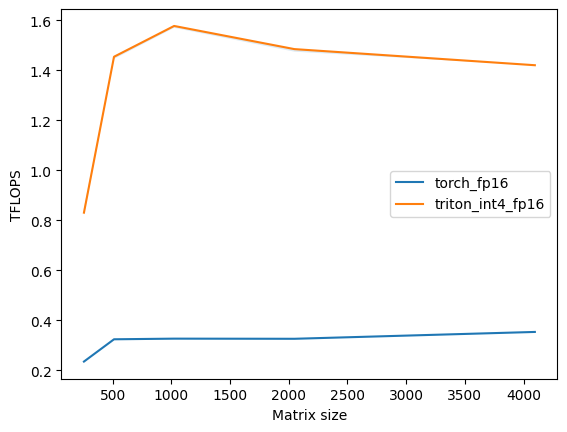

In [ ]:
# %%
# Benchmark
# ---------
#
# Square Matrix Performance
# ~~~~~~~~~~~~~~~~~~~~~~~~~~
#
# We can now compare the performance of our kernel against that of cuBLAS or rocBLAS. Here we focus on square matrices,
# but feel free to arrange this script as you wish to benchmark any other matrix shape.

configs = []
configs.append(
    triton.testing.Benchmark(
        x_names=["M", "N", "K"],  # Argument names to use as an x-axis for the plot
        x_vals=[256, 
                512,
                1024,
                2048,
                4096,
        ],
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
        line_vals=["torch_fp16", "triton_int4_fp16"],  # Label name for the lines
        line_names=["torch_fp16", "triton_int4_fp16"],  # Line styles
        #styles=[("green", "-"), ("blue", "-")],
        ylabel="TFLOPS",  # Label name for the y-axis
        xlabel="Matrix size",
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    ))


@triton.testing.perf_report(configs)
def benchmark(M, K, N, provider):
    y = torch.randn(M, K, dtype=torch.float16, device="cuda") / (M * K)
    x_compressed = torch.randint(0, 255, (K, N // 2), dtype=torch.uint8, device="cuda")
    x_decompressed = decode_uint8_to_int4_python(x_compressed).reshape(K, N).to(torch.float16)
    
    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch_fp16":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(y, x_decompressed), quantiles=quantiles)
    if provider == "triton_int4_fp16":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_int4_fp16(y, x_compressed), quantiles=quantiles)
        # print(matmul_kernel.best_config)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

benchmark.run(show_plots=False, print_data=True)